TESTED FEATURES: 
Index(['vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10', 'acc15',
       'acc30', 'acc60', 'stoch12', 'stochDiff6012', 'RSIhl_diff',
       'RSIhl_diffROC', 'HLdiff', 'HL2', 'H2L', 'HLdiff12', 'HLdiff21', 'vol',
       'vol10', 'vol15', 'vol30', 'vol60', 'volD10', 'volD15', 'volD30',
       'volD60', 'vpm5', 'vpm10', 'vpm15', 'vpm30', 'vpm60', 'ToD', 'DoW',
       'mo'],
      dtype='object')
TESTING FOR: 
r30
X shape == (224859, 10, 36).
y shape == (224859,).
Raw Sample Count: 224859
65769
24600
Running on: GPU

Epoch 1/1000
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 34s 13ms/step - R2Score: -0.9008 - loss: 0.0655 - root_mean_squared_error: 0.2539 - val_R2Score: -0.2532 - val_loss: 0.0386 - val_root_mean_squared_error: 0.1965 - learning_rate: 0.0010
Epoch 2/1000
2460/2460 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step - R2Score: -0.2559 - loss: 0.0431 - root_mean_squared_error: 0.2076 - val_R2Score: 0.0098 - val_loss: 0.0305 - val_root_mean_squared_error: 0.1746 - learning_rate: 

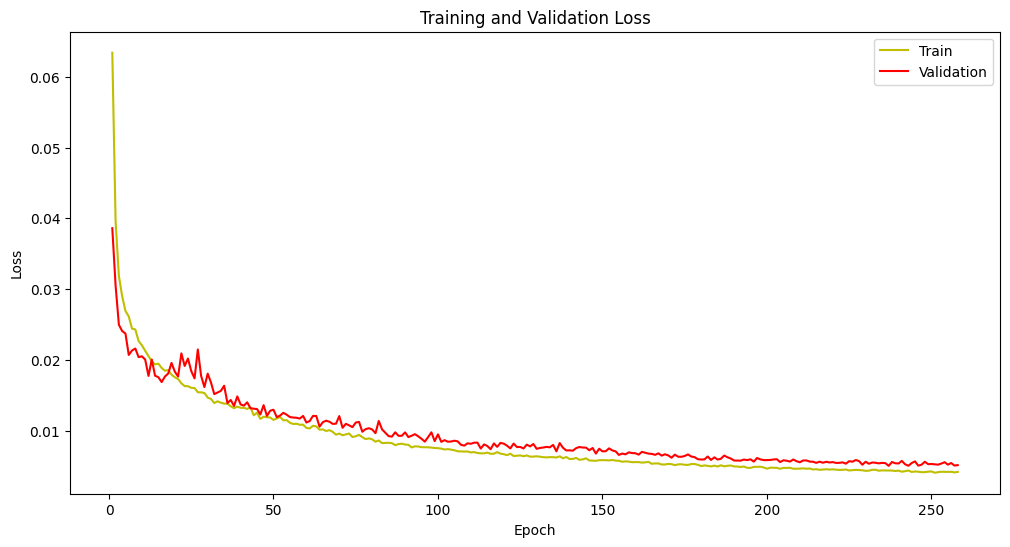

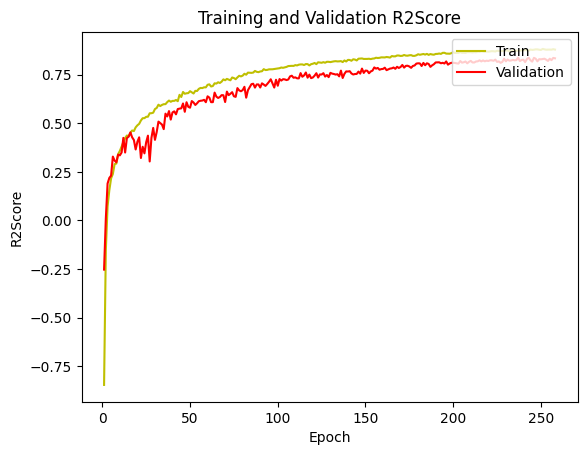

154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


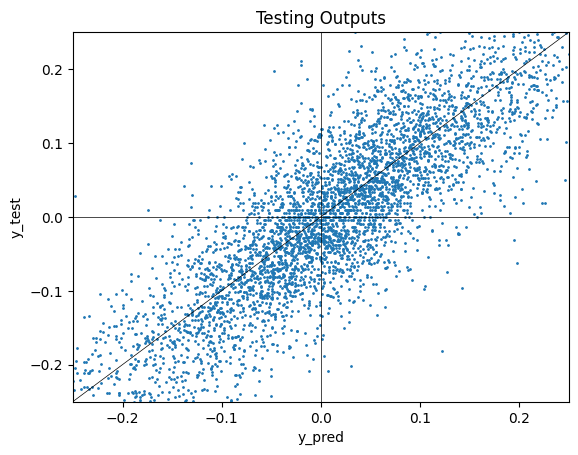

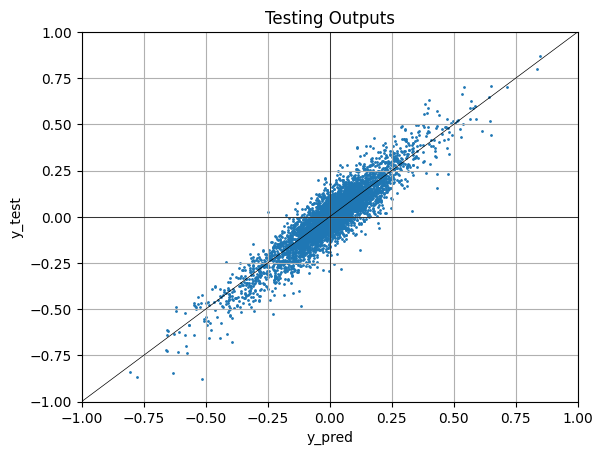

Directional Accuracy:		 84.38


ZeroDivisionError: division by zero

In [ ]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted_1-8.csv')

#data = data[:1000]

#      'Dr1' 'Dr3' 'Mr1' 'Mr3' 
testFor = 'r30'
timeSteps = 10
tType = testFor[0]
#testing random feature drops
#TREND

data = data.drop(columns=['FT','FT.1'])
#data = data.drop(columns=['FT'])
#--------------------------------------
#targets-------------------------------
#r----  1   2   3   5   10  15  30  60
match testFor:
    case 'r1':
        data = data.drop(columns=['r2','r3','r5','r10','r15','r30','r60'])
    case 'r2':
        data = data.drop(columns=['r1','r3','r5','r10','r15','r30','r60'])
    case 'r3':
        data = data.drop(columns=['r1','r2','r5','r10','r15','r30','r60'])
    case 'r5':
        data = data.drop(columns=['r1','r2','r3','r10','r15','r30','r60'])
    case 'r10':
        data = data.drop(columns=['r1','r2','r3','r5','r15','r30','r60'])
    case 'r15':
        data = data.drop(columns=['r1','r2','r3','r5','r10','r30','r60'])
    case 'r30':
        data = data.drop(columns=['r1','r2','r3','r5','r10','r15','r60'])
    case 'r60':
        data = data.drop(columns=['r1','r2','r3','r5','r10','r15','r30'])
#data['Dr3_Model'] = 0
#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)
#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

#setting data for LSTM
def reformat_to_lstm(X, time_steps=timeSteps):
    X_lstm, y_lstm = [], []
    
    for i in range(time_steps, len(X)):
        # Collect previous time_steps rows for X
        X_lstm.append(X[i-time_steps:i])  
        # The corresponding y value for the last time step in the sequence
    
    X_lstm = np.array(X_lstm)
    
    return X_lstm
# Standardize the features
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = MinMaxScaler(feature_range=(-1,1))
scaler1.fit(X)
X = scaler1.transform(X)

X = reformat_to_lstm(X, timeSteps)
y = y[timeSteps:]
y = np.array(y)

#print(X[0])
#print(y[0])

print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))




def remove_zero_mo_samples(X, y):
    # Get the 'MO' column (index 34 for 0-based indexing) for all time steps and samples
    non_zero_indices = (X[:, timeSteps-1, len(Xfeatures)-1] >= 0)
    # Filter X and y using these indices
    X_filtered = X[non_zero_indices]
    y_filtered = y[non_zero_indices]
    return X_filtered, y_filtered

def remove_extra_filter(X, y):
    indices = (X[:, timeSteps-1, len(Xfeatures)-3] >= -0.321405)#-3 is ToD, this value is 9:30am
    X = X[indices]
    y = y[indices]
    indices = (X[:, timeSteps-1, len(Xfeatures)-3] <= 0.0366699)#-3 is ToD, this value is 12:00pm
    X = X[indices]
    y = y[indices]
    return X, y
print(f'Raw Sample Count: {len(X)}')
X, y = remove_zero_mo_samples(X, y)
print(len(X))
X, y = remove_extra_filter(X, y)
print(len(X))

#mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
#print(mos)
#print(len(X))
#print(X[0])
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


#LEARNING RATES____________________________________________________________________________________________
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.01,
    decay_steps=100,
    decay_rate=0.997,
    staircase=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.98, 
    patience=8, 
    min_lr=1e-6
)

#LOSS FUNCTION
from keras.saving import get_custom_objects
from keras.saving import register_keras_serializable
get_custom_objects().clear()
#CUSTOM LOSS 1_______________________________________________________________________________________________
from keras.src import ops
from keras.src.losses.loss import squeeze_or_expand_to_same_rank
@register_keras_serializable(name="skew_loss")
def skew_loss(y_true,y_pred,sFact=4):
    #return ops.mean(ops.square((y_pred-y_true)*(1+sFact*tf.cast(((y_true>0 & y_pred<y_true) | (y_true<0 & y_pred>y_true)),tf.float32))),axis=-1)
    y_pred = ops.convert_to_tensor(y_pred)
    y_true = ops.convert_to_tensor(y_true, dtype=y_pred.dtype)
    #y_true, y_pred = squeeze_or_expand_to_same_rank(y_true, y_pred)
    error = ops.subtract(y_pred, y_true)
    a = ops.convert_to_tensor(ops.cast(y_pred > 0,tf.float32), dtype=tf.float32)
    b = ops.convert_to_tensor(ops.cast(y_pred < 0,tf.float32), dtype=tf.float32)
    c = ops.convert_to_tensor(ops.cast(y_true >= y_pred,tf.float32), dtype=tf.float32)
    d = ops.convert_to_tensor(ops.cast(y_true <= y_pred,tf.float32), dtype=tf.float32)
    #e = ops.convert_to_tensor(ops.cast(y_true >= 0.05,tf.float32), dtype=tf.float32)
    #f = ops.convert_to_tensor(ops.cast(y_true <= -0.05,tf.float32), dtype=tf.float32)
    h = ops.convert_to_tensor(0.1, dtype=error.dtype)
    return ops.mean(
        ops.where(
            a*c+b*d==1,# or (b and d),
            h*ops.square(error),
            ops.square(error)
        ))

opt1 = SGD(learning_rate=0.01)
opt2  = tf.keras.optimizers.Adam(learning_rate=0.001)
opt3 = SGD(learning_rate=lr_schedule)
opt4 = SGD(learning_rate=0.001, momentum=0.9)
opt5 = tf.keras.optimizers.Adam(learning_rate=0.001)

#BUILD AND LOAD MODEL__________________________________________________________________________________________


#print(X_train.shape[0]/time_steps)
#X_train = np.reshape(X_train,((X_train.shape[0]//time_steps), time_steps, 35))  # Reshape to (batch_size, 5 time steps, 35 features)
#y_train = y.reshape(1,-1)
from tensorflow.keras import regularizers

def build_LSTM_model():
    #time_steps=5
    n_features=len(Xfeatures)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
        tf.keras.layers.LSTM(512, activation='tanh', recurrent_dropout=0.1, return_sequences=False),#, kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        tf.keras.layers.Dropout(0.1),
        #tf.keras.layers.Dense(256, activation='relu'),#,kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=opt4,
                  loss=skew_loss
                  ,metrics=['R2Score','root_mean_squared_error'])
    return model

def load_model():
    #loaded_model = tf.keras.models.load_model('tupleTrain.keras', custom_objects={'custom_loss':custom_loss})
    loaded_model = tf.keras.models.load_model('r30_10s_LSTM_skew2.keras')
    loaded_model.compile(optimizer=opt4,
                         loss=skew_loss
                         , metrics=['R2Score','root_mean_squared_error'])
    return loaded_model

#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 2000

early_stopping = EarlyStopping(monitor='val_loss', patience=102, mode='min', restore_best_weights=True)

cmp = 'C'
if tf.config.list_physical_devices('GPU'):
    cmp = 'G'
with tf.device('/'+cmp+'PU:0'):
    print('Running on: '+cmp+'PU\n')
    model = build_LSTM_model()
    loaded_model = load_model()
    used_model = loaded_model
    history = used_model.fit(X_train, y_train, epochs=epochs,\
                        shuffle=False, verbose=1, validation_data=(X_test, y_test),\
                        batch_size=8,callbacks=[reduce_lr, early_stopping])

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

# LOSS
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'y', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY

plt.plot(epochs, history.history['R2Score'], 'y', label='Training R2')
plt.plot(epochs, history.history['val_R2Score'], 'r', label='Validation R2')
plt.title('Training and Validation R2Score')
plt.xlabel('Epoch')
plt.ylabel('R2Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


#predicting the test set results
y_pred = used_model.predict(X_test) 


plt.scatter(y_pred, y_test, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-.25,.25)
plt.ylim(-.25,.25)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_test, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()
#DIRECTIONAL ACCURACY #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  
tp, fp, tn, fn = 0, 0, 0, 0
tp5, fp5, tn5, fn5 = 0, 0, 0, 0
for i in range(len(y_pred)):
    if(y_pred[i]>0):
        if(y_test[i]>0):
            tp+=1
        if(y_test[i]<0):
            fp+=1
        if(y_pred[i]>=5):
            if(y_test[i]>0):
                tp5+=1
            if(y_test[i]<0):
                fp5+=1
    if(y_pred[i]<0):
        if(y_test[i]<0):
            tn+=1
        if(y_test[i]>0):
            fn+=1
        if(y_pred[i]<=-5):
            if(y_test[i]<0):
                tn5+=1
            if(y_test[i]>0):
                fn5+=1
directionalAccuracy = ((tp+tn)/(tp+fp+tn+fn))*10000//1/100
print('Directional Accuracy:\t\t',directionalAccuracy)
directionalAccuracy5guess = ((tp5+tn5)/(tp5+fp5+tn5+fn5))*10000//1/100
print('Directional Accuracy >(+/-)5:\t',directionalAccuracy5guess)

In [15]:
used_model.save('r30_10s_LSTM_12.keras')

In [78]:
import numpy as np
from sklearn.metrics import mean_squared_error

def walk_forward_validation(X, y, model, n_splits=20, test_size=0.2):
    """
    Perform walk-forward validation for an LSTM model.

    Parameters:
    X (np.ndarray): 3D array of features with shape (n_samples, time_steps, n_features)
    y (np.ndarray): 1D array of labels with shape (n_samples,)
    model (tf.keras.Model): Compiled LSTM model
    n_splits (int): Number of walk-forward splits
    test_size (float): Proportion of the data to use as the test set in each split

    Returns:
    list: MSE scores for each split
    """
    n_samples = X.shape[0]
    test_set_size = int(test_size * n_samples)
    
    mse_scores = []

    # Split the data into n_splits segments
    for i in range(n_splits):
        # Define the index range for the training set (everything before the test set)
        train_end = int((i + 1) * (n_samples - test_set_size) / n_splits)

        # Define the test set
        X_train, X_test = X[:train_end], X[train_end:train_end + test_set_size]
        y_train, y_test = y[:train_end], y[train_end:train_end + test_set_size]

        # Ensure that your model is recompiled and retrained in each fold
        model_copy = tf.keras.models.load_model(model)
        model_copy.compile(optimizer='adam', loss='mse')  # Assuming MSE for regression

        # Fit the model on the current training set
        model_copy.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

        # Make predictions on the test set
        y_pred = model_copy.predict(X_test)

        # Calculate the mean squared error for this fold
        mse = mean_squared_error(y_test, y_pred)
        mse_scores.append(mse)

        print(f'Fold {i+1}/{n_splits}, MSE: {mse}')

    return mse_scores

# Example usage:
# Assuming you have already defined `X`, `y`, and compiled your LSTM model
# mse_scores = walk_forward_validation(X, y, lstm_model, n_splits=5, test_size=0.2)
X_vals = X_test
y_vals = y_test
print('X shape:',X_vals.shape,'\ny shape:',y_vals.shape)
scores = walk_forward_validation(X_test, y_test, 'LSTM_testtest.keras')
avgScore = 0
for score in scores:
    avgScore+=score
avgScore/=len(scores)

print('Average MSE:',avgScore)

X shape: (3019, 48, 31) 
y shape: (3019,)


ValueError: File not found: filepath=LSTM_testtest.keras. Please ensure the file is an accessible `.keras` zip file.

In [11]:
data.corr()

,vel5,vel10,vel15,vel30,vel60,acc5,acc10,acc15,acc30,acc60,...,volD60,vpm5,vpm10,vpm15,vpm30,vpm60,ToD,DoW,MO,Dr1
vel5,1.000000,0.696269,0.566629,0.404792,0.292516,0.717757,0.488963,0.396644,0.279971,0.209327,...,-0.040104,0.399169,0.295397,0.252108,0.187244,0.122011,0.007345,-0.006288,-0.005597,-0.030087
vel10,0.696269,1.000000,0.806148,0.574039,0.409941,-0.000033,0.715761,0.566122,0.401907,0.289201,...,-0.056399,0.261988,0.431247,0.351803,0.258081,0.170056,0.010114,-0.008862,-0.006926,-0.030580
vel15,0.566629,0.806148,1.000000,0.702885,0.499764,0.007407,0.289400,0.711311,0.494297,0.351262,...,-0.063678,0.211814,0.339981,0.446810,0.313587,0.208718,0.012498,-0.010801,-0.006752,-0.021263
vel30,0.404792,0.574039,0.702885,1.000000,0.706232,0.007091,0.011623,0.000013,0.707956,0.498343,...,-0.069082,0.146675,0.227690,0.295953,0.459010,0.297900,0.017696,-0.015124,-0.005017,-0.009727
vel60,0.292516,0.409941,0.499764,0.706232,1.000000,0.009827,0.012296,0.004736,-0.000029,0.702112,...,-0.040721,0.105265,0.158133,0.204836,0.309917,0.452845,0.025193,-0.019204,-0.009746,-0.002594
acc5,0.717757,-0.000033,0.007407,0.007091,0.009827,1.000000,-0.013115,0.003432,0.000202,0.011057,...,-0.001119,0.301999,-0.006754,0.009999,0.010539,0.005033,0.000411,-0.000164,-0.001095,-0.012246
acc10,0.488963,0.715761,0.289400,0.011623,0.012296,-0.013115,1.000000,0.395404,0.004165,0.011784,...,-0.014793,0.191872,0.320990,0.125447,0.007287,0.002171,0.000022,-0.000255,-0.004608,-0.026688
acc15,0.396644,0.566122,0.711311,0.000013,0.004736,0.003432,0.395404,1.000000,-0.004650,0.001396,...,-0.021239,0.152865,0.253008,0.335755,-0.012689,-0.000914,0.000070,-0.000236,-0.004520,-0.020336
acc30,0.279971,0.401907,0.494297,0.707956,-0.000029,0.000202,0.004165,-0.004650,1.000000,0.003486,...,-0.056943,0.102190,0.163888,0.213747,0.339243,-0.030884,-0.000141,-0.002206,0.002634,-0.011194
acc60,0.209327,0.289201,0.351262,0.498343,0.702112,0.011057,0.011784,0.001396,0.003486,1.000000,...,-0.031837,0.072164,0.108224,0.140920,0.214447,0.323144,0.000812,-0.001878,0.000152,0.000266


In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0
